# Exercise 2:

We are building a model which predicts the average daily price of the next day using 2 methods: a moving average of 14 days and the fbprophet package

Let's start!

# 1-Data Understanding


### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
from datetime import date as dt
from dateutil import parser
import calendar
import seaborn as sns
import os
import tarfile
from six.moves import urllib
import matplotlib.image as mpimg
import unittest
from datetime import date, timedelta
!pip install --upgrade folium


Requirement already up-to-date: folium in c:\users\sheri\anaconda3\lib\site-packages (0.10.0)


### 1.1:Collect Initial Data

#### Read the gas prices and stations .csv files and check some rows to get familiar with the data

Note: Data can be downloaded from: https://creativecommons.tankerkoenig.de/, there you can also find detailed description of the columns included.

In [2]:
#read the csv files and store them into variables "data_prices" & "data_stations", it was noted that the .csv file is ";" separated
data_prices = pd.read_csv('example_sprit_cut_prices.csv', sep=';')
data_stations = pd.read_csv('example_sprit_cut_station.csv', sep=';')

#print first 5 rows of the file + header
data_prices.head()
data_stations.head()

,ID,VERSION,VERSION_TIME,NAME,BRAND,STREET,HOUSE_NUMBER,POST_CODE,PLACE,PUBLIC_HOLIDAY_IDENTIFIER,LAT,LNG
0,d37bee76-91b6-485a-b974-24f1b0d391fa,4,2015-01-09 10:26:15.000000,Aral Tankstelle,ARAL,An der Tagweide,2,76139,Karlsruhe,\N,49.020280,8.459429
1,51d4b652-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET MANNHEIM UNTERMUEHLAUSTRASSE 83,JET,UNTERMUEHLAUSTRASSE 83,\N,68169,MANNHEIM,\N,49.508962,8.467691
2,c7caf231-0e47-40db-92de-9349a2eb2bef,4,2014-09-26 13:24:57.000000,Aral Tankstelle,ARAL,Trippstadter Straße,69,67663,Kaiserslautern,\N,49.433754,7.757465
3,51d4b53b-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET KAISERSLAUTERN PARISER STR. 167,JET,PARISER STR. 167,\N,67655,KAISERSLAUTERN,\N,49.442200,7.748360
4,51d4b70f-a095-1aa0-e100-80009459e03a,796,2015-09-28 21:00:13.000000,JET GERMERSHEIM MUENCHENER STRASSE 12,JET,MUENCHENER STRASSE 12,\N,76726,GERMERSHEIM,\N,49.226800,8.374400


### 1.2:Describe Data

Now lets explore all columns of the 2 tables, and understand what each column means.

#### Gas prices data:

It seems we have 6 columns in our gas prices data set:

* STID --> Station ID
* E5 --> E5 price (in tenths of a cent)
* E10 --> E10 price (in tenths of a cent)
* DIESEL --> Diesel price (in tenths of a cent)
* DATE_CHANGED --> Date and time of change
* CHANGED --> Bitmask for the change (to indicate which type's price has changed)

The bitmask for the price change is given in the below table:

| action | diesel | E5 | E10 |
| --- | --- | --- | --- |
| new | 3 | 12 | 48 |
| removed | 2 | 8th | 32 |
| changed | 1 | 4 | 16 |

#### Gas stations data:

It seems we have 12 columns in our gas prices data set:

* ID --> unique, steady ID of the gas station
* VERSION --> Version number, assigned by the operator (not important)
* VERSION_TIME --> Information on the last change of the version number, issued by the operator.
* NAME --> Name of gas station
* BRAND --> Brand of gas station
* STREET --> Street of gas station
* HOUSE_NUMBER --> House number of gas station
* POST_CODE --> Postal code of gas station
* PLACE --> Name of city/village
* PUBLIC_HOLIDAY_IDENTIFIER --> Abbreviation for state
* LAT --> Latitude of gas station
* LNG --> Longitude of gas station

### 1.3: Verifying Data Quality

Now lets have some statistics to know the quality of the data we have.


In [3]:
#For Prices table

data_prices.info() #get info about datatypes of columns, and if any rows have missing data
data_prices.describe() #get initial statistics on the table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2189526 entries, 0 to 2189525
Data columns (total 6 columns):
STID            object
E5              int64
E10             int64
DIESEL          int64
DATE_CHANGED    object
CHANGED         int64
dtypes: int64(4), object(2)
memory usage: 100.2+ MB


,E5,E10,DIESEL,CHANGED
count,2.189526e+06,2.189526e+06,2.189526e+06,2.189526e+06
mean,1.434320e+03,1.404088e+03,1.247491e+03,1.871165e+01
std,2.091502e+02,2.116844e+02,1.037774e+02,8.031150e+00
min,-1.000000e+00,-1.000000e+00,-1.000000e+00,1.000000e+00
25%,1.379000e+03,1.349000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.324000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


#### Prices:
* There are no missing data
* The min. of E5, E10 and DIESEL columns is negative, which is not correct for a price value, thus all rows containing negative prices should be dropped, as we can't deduce the value in any way.
* The max. of E5, E10 is 9999 which seems illogical value, so these rows should be dropped.

In [4]:
#For Stations table

data_stations.info() #get info about datatypes of columns, and if any rows have missing data
data_stations.describe() #get initial statistics on the table

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 824 entries, 0 to 823
Data columns (total 12 columns):
ID                           824 non-null object
VERSION                      824 non-null int64
VERSION_TIME                 824 non-null object
NAME                         824 non-null object
BRAND                        802 non-null object
STREET                       820 non-null object
HOUSE_NUMBER                 674 non-null object
POST_CODE                    820 non-null object
PLACE                        820 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    824 non-null object
LAT                          824 non-null float64
LNG                          824 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 77.3+ KB


,VERSION,LAT,LNG
count,824.000000,824.000000,824.000000
mean,131.427184,49.322226,8.191227
std,269.682766,0.254722,0.283228
min,1.000000,48.800790,7.505350
25%,1.000000,49.106052,8.106655
50%,4.000000,49.374500,8.289707
75%,22.250000,49.509410,8.404923
max,881.000000,49.799397,8.499941


#### Stations:
* There are missing data in BRAND, STREET, HOUSE_NUMBER, POST_CODE, PLACE columns
* For the BRAND missing rows, they should be deleted
* There are some BRANDs that need to unify its name
* The missing STREET rows can be kept, since we already have their lat/long

#### Conclusion:
We need data cleaning before we start analyzing our dataset.

# 2-Data Preparation

### 2.1:Clean Data

Now lets start cleaning our data.

#### Cleaning Prices table:

* Remove duplicates:

In [5]:
data_prices.drop_duplicates(inplace=True)

* The min. value for E5, E10 and DIESEL are negative, we need to remove these rows:

In [6]:
data_prices=data_prices[data_prices['E5']>0] #drop rows having E5 price =<0
data_prices=data_prices[data_prices['E10']>0] #drop rows having E10 price =<0
data_prices=data_prices[data_prices['DIESEL']>0] #drop rows having DIESEL price =<0
data_prices.describe()

,E5,E10,DIESEL,CHANGED
count,1.075425e+06,1.075425e+06,1.075425e+06,1.075425e+06
mean,1.457085e+03,1.429118e+03,1.247725e+03,1.900296e+01
std,1.045053e+02,9.922577e+01,1.024969e+02,7.726616e+00
min,8.000000e+00,1.000000e+03,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.430000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.319000e+03,2.100000e+01
max,9.999000e+03,9.999000e+03,1.129000e+04,6.300000e+01


* Remove rows having prices = NaN

In [7]:
data_prices=data_prices[np.isfinite(data_prices['E5'])]
data_prices=data_prices[np.isfinite(data_prices['E10'])]
data_prices=data_prices[np.isfinite(data_prices['DIESEL'])]
#data_prices.describe()


* The max value for E5, E10 and DIESEL are not reasonable, so we will drop all rows having values >2000

In [8]:
data_prices=data_prices[data_prices['E5'] < 2000] #drop rows having E5 values >2000
data_prices=data_prices[data_prices['E10'] < 2000] #drop rows having E10 values >2000
data_prices=data_prices[data_prices['DIESEL'] < 2000] #drop rows having DIESEL values >2000
data_prices.describe()

,E5,E10,DIESEL,CHANGED
count,1.075412e+06,1.075412e+06,1.075412e+06,1.075412e+06
mean,1.456997e+03,1.429060e+03,1.247650e+03,1.900292e+01
std,1.011090e+02,9.694896e+01,9.944750e+01,7.726382e+00
min,8.000000e+00,1.000000e+03,9.990000e+02,1.000000e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01
50%,1.459000e+03,1.429000e+03,1.239000e+03,2.100000e+01
75%,1.529000e+03,1.499000e+03,1.319000e+03,2.100000e+01
max,1.999000e+03,1.999000e+03,1.999000e+03,6.300000e+01


The prices table now looks ready to be analyzed. Now, lets move on to clean the stations table.

#### Cleaning Stations table:

* Remove duplicates:

In [9]:
data_stations.drop_duplicates(inplace=True)

* The BRAND column contains empty values, need to be removed. Also, there are some brand names that needs to be unified:

In [10]:
data_stations['BRAND'].unique() #get unique values for BRAND
data_stations=data_stations[data_stations['BRAND'] != '\\N']; #remove rows having BRAND = '\N'
data_stations.loc[data_stations['BRAND'] == 'Supermarkt Tankstelle','BRAND']= 'Supermarkt-Tankstelle' #adjust rows having BRAND = 'Supermarkt Tankstelle' to 'Supermarkt-Tankstelle' to unify the name
data_stations.dropna(subset=['BRAND'], inplace=True) #remove empty BRAND rows
data_stations=data_stations[data_stations['BRAND'] != 'nicht mehr aktiv'] #remove stations that are no more active
data_stations['BRAND'].unique()
data_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 709
Data columns (total 12 columns):
ID                           397 non-null object
VERSION                      397 non-null int64
VERSION_TIME                 397 non-null object
NAME                         397 non-null object
BRAND                        397 non-null object
STREET                       395 non-null object
HOUSE_NUMBER                 323 non-null object
POST_CODE                    395 non-null object
PLACE                        395 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    397 non-null object
LAT                          397 non-null float64
LNG                          397 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 40.3+ KB


* Check rows having empty STREET, HOUSE_NUMBER, POST_CODE, PLACE:

In [11]:
data_stations[data_stations['PLACE'].isnull()] #get stations having empty PLACE (Only 2 stations)

#After searching using their lat/long, both stations are located in Landau, and got their postal code from the URL below:
#https://www.latlong.net/Show-Latitude-Longitude.html
data_stations.loc[data_stations['PLACE'].isnull(),'PLACE']= 'Landau'
data_stations.loc[data_stations['ID'] == 'a21e3ed2-6d03-478f-32a3-9f33202182bc','POST_CODE']= '76829'
data_stations.loc[data_stations['ID'] == 'e69a923a-ba11-409b-2720-2b908ed66498','POST_CODE']= '76863'

data_stations['PLACE'].unique()

array(['Karlsruhe', 'MANNHEIM', 'Kaiserslautern', 'KAISERSLAUTERN',
       'GERMERSHEIM', 'BAD DUERKHEIM', 'ALZEY', 'MUTTERSTADT',
       'Iffezheim', 'Grünstadt', 'Bellheim', 'Mannheim',
       'Annweiler-Queichhambach', 'WORMS', 'Herxheim',
       'Karlsruhe-Knielingen', 'LANDAU', 'Jockgrim',
       'Lampertheim-Hofheim', 'Ludwigshafen', 'Oberhausen', 'Pirmasens',
       'Klingenmünster', 'Rodalben', 'Saalstadt', 'Schifferstadt',
       'Rastatt', 'Landau', 'Waldsee', 'Edenkoben', 'Steinweiler',
       'Thaleischweiler-Fröschen', 'Bad Dürkheim', 'Freckenfeld',
       'Speyer', 'Bad Bergzabern', 'Landstuhl', 'Haßloch', 'Westhofen',
       'Lampertheim', 'Dannstadt-Schauernhe', 'Au am Rhein', 'Eppenbrunn',
       'Kuppenheim', 'Phillipsburg', 'Rheinstetten', 'Weilerbach',
       'NEUSTADT', 'Queidersbach', 'Joehlingen', 'Worms', 'Otterberg',
       'Hochspeyer', 'Carlsberg', 'Dettenheim-Liedolsheim', 'Wattenheim',
       'Alzey', 'Karlsbad', 'RUELZHEIM', 'Ettlingen OT Schöllbronn',
   

* Now the PLACE column has the cities names, but some are in capital letters, some in small letters. We need to unify the format:

In [12]:
#change PLACE text to "title format" which means first character is capital, others are small
for index, row in data_stations.iterrows():
    data_stations.loc[index,'PLACE'] = data_stations.loc[index,'PLACE'].title()

data_stations.drop_duplicates(inplace=True) #remove any duplicates that may show up after the cities naming format
data_stations['PLACE'].unique()

data_stations.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 397 entries, 0 to 709
Data columns (total 12 columns):
ID                           397 non-null object
VERSION                      397 non-null int64
VERSION_TIME                 397 non-null object
NAME                         397 non-null object
BRAND                        397 non-null object
STREET                       395 non-null object
HOUSE_NUMBER                 323 non-null object
POST_CODE                    397 non-null object
PLACE                        397 non-null object
PUBLIC_HOLIDAY_IDENTIFIER    397 non-null object
LAT                          397 non-null float64
LNG                          397 non-null float64
dtypes: float64(2), int64(1), object(9)
memory usage: 40.3+ KB


### 2.2: Select Data

##### Now our data is cleaned, we need to join the 2 tables using the key, which is in our case the "Station ID":

In [13]:
#Inner join both tables using "station id" as a key, output is stored in a new dataframe called "data_complete"
data_complete = pd.merge(left=data_prices,right=data_stations, how='inner',  left_on='STID', right_on='ID')

data_complete[data_complete['BRAND'].isnull()] #make sure it was inner join and not any other type.

data_complete.head()
data_complete.describe()

,E5,E10,DIESEL,CHANGED,VERSION,LAT,LNG
count,1.056254e+06,1.056254e+06,1.056254e+06,1.056254e+06,1.056254e+06,1.056254e+06,1.056254e+06
mean,1.457402e+03,1.429474e+03,1.248009e+03,1.900816e+01,1.291684e+02,4.932019e+01,8.205228e+00
std,1.011455e+02,9.699329e+01,9.955152e+01,7.727058e+00,2.651364e+02,2.543584e-01,2.777877e-01
min,1.000000e+03,1.000000e+03,9.990000e+02,1.000000e+00,1.000000e+00,4.880079e+01,7.505350e+00
25%,1.379000e+03,1.359000e+03,1.169000e+03,2.100000e+01,1.000000e+00,4.910107e+01,8.115410e+00
50%,1.459000e+03,1.439000e+03,1.239000e+03,2.100000e+01,4.000000e+00,4.937260e+01,8.310054e+00
75%,1.529000e+03,1.499000e+03,1.329000e+03,2.100000e+01,2.200000e+01,4.950381e+01,8.411643e+00
max,1.999000e+03,1.999000e+03,1.999000e+03,6.300000e+01,8.810000e+02,4.979940e+01,8.499941e+00


#### We will parse the DATE_CHANGED column to year, month, day, hour, minute, seconds so that we can easily analyze over a specific month, hour...etc:

In [14]:
#Function to parse date in format yy-mm-dd hh:mm:ss, then separates it to year, month, day, hour, minute, second
def parse_date(date_string):
    year, month, split_string = date_string.split('-')
    day, time = split_string.split(' ')
    hour, minute, second = time.split(':')
    return year, month, day, hour, minute, second

#Function to take the dates column, and returns 6 lists (year, month, day, hour, minute, second)
def format_date(dates):
    year_column, month_column, day_column, hour_column, minute_column, second_column, date_column, weekday_column =[],[],[],[],[],[],[],[]
    for date_loop in dates:
        year, month, day, hour, minute, second= parse_date(date_loop)
        year_column.append(year)
        month_column.append(month)
        day_column.append(day)
        hour_column.append(hour)
        minute_column.append(minute)
        second_column.append(second)
        date_column.append(year+"-"+month+"-"+day)
        weekday_column.append(calendar.day_name[parser.parse(year+"-"+month+"-"+day).weekday()])
    return year_column,month_column,day_column,hour_column,minute_column,second_column,date_column,weekday_column

#Function to add the 6 lists to our dataframe
def add_dates(year_column,month_column,day_column,hour_column,minute_column,second_column,date_column,weekday_column):
    data_complete['year'] = year_column 
    data_complete['month'] = month_column 
    data_complete['day'] = day_column 
    data_complete['hour'] = hour_column 
    data_complete['minute'] = minute_column 
    data_complete['second'] = second_column 
    data_complete['date'] = date_column
    data_complete['weekday'] = weekday_column

dates = data_complete.values[:,4]
year_column,month_column,day_column,hour_column,minute_column,second_column,date_column,weekday_column = format_date(dates)
add_dates(year_column,month_column,day_column,hour_column,minute_column,second_column,date_column,weekday_column)


data_complete.head()


,STID,E5,E10,DIESEL,DATE_CHANGED,CHANGED,ID,VERSION,VERSION_TIME,NAME,...,LAT,LNG,year,month,day,hour,minute,second,date,weekday
0,01bf5a06-4248-43a5-9524-56123fa3ab2f,1589,1549,1389,2014-10-02 05:22:01.000000,21,01bf5a06-4248-43a5-9524-56123fa3ab2f,12,2015-04-27 12:00:03.000000,Esso Tankstelle,...,49.633409,8.273847,2014,10,02,05,22,01.000000,2014-10-02,Thursday
1,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1369,2014-10-02 05:26:01.000000,21,01bf5a06-4248-43a5-9524-56123fa3ab2f,12,2015-04-27 12:00:03.000000,Esso Tankstelle,...,49.633409,8.273847,2014,10,02,05,26,01.000000,2014-10-02,Thursday
2,01bf5a06-4248-43a5-9524-56123fa3ab2f,1569,1529,1359,2014-10-02 09:06:01.000000,1,01bf5a06-4248-43a5-9524-56123fa3ab2f,12,2015-04-27 12:00:03.000000,Esso Tankstelle,...,49.633409,8.273847,2014,10,02,09,06,01.000000,2014-10-02,Thursday
3,01bf5a06-4248-43a5-9524-56123fa3ab2f,1539,1499,1339,2014-10-03 12:14:01.000000,21,01bf5a06-4248-43a5-9524-56123fa3ab2f,12,2015-04-27 12:00:03.000000,Esso Tankstelle,...,49.633409,8.273847,2014,10,03,12,14,01.000000,2014-10-03,Friday
4,01bf5a06-4248-43a5-9524-56123fa3ab2f,1529,1489,1329,2014-10-03 14:14:01.000000,21,01bf5a06-4248-43a5-9524-56123fa3ab2f,12,2015-04-27 12:00:03.000000,Esso Tankstelle,...,49.633409,8.273847,2014,10,03,14,14,01.000000,2014-10-03,Friday


****Unit testing the functions****

Now we will unit test the functions to ensure their proper functionality:

In [15]:
#Test function "parse_date" that parses the date string into year, month, day, hour, minute, second
import unittest

class TestNotebook(unittest.TestCase):

    def test_parse_date(self):
        self.assertEqual(parse_date("2014-10-02 05:22:01.000000"), ("2014","10","02","05","22","01.000000"))


unittest.main(argv=[''], verbosity=2, exit=False)

test_parse_date (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


In [16]:
#Test function "parse_date" that parses the date string into year, month, day, hour, minute, second, year-month-day, weekday
import unittest

class TestNotebook(unittest.TestCase):

    def test_format_date(self):
        self.assertEqual(format_date(["2014-10-02 05:22:01.000000"]), (["2014"],["10"],["02"],["05"],["22"],["01.000000"],["2014-10-02"],["Thursday"]))


unittest.main(argv=[''], verbosity=2, exit=False)

test_format_date (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.003s

OK


## 3: Prepare dataset

### 3.1: Average daily

In [17]:
#average daily price per station
data_from_seven_to_twenty = data_complete.query('hour >= "07" and hour < "20"')
data_daily_average = data_from_seven_to_twenty.groupby(['STID','date'],as_index=False)['E5','E10','DIESEL'].mean()
data_daily_average.columns
#data_daily_average = data_daily_average.to_frame()
#type(data_daily_average)

Index(['STID', 'date', 'E5', 'E10', 'DIESEL'], dtype='object')

In [18]:
#get minimum and maximum dates per station
min_date_per_station = data_from_seven_to_twenty.groupby(['STID'])['DATE_CHANGED'].min()
max_date_per_station = data_from_seven_to_twenty.groupby(['STID'])['DATE_CHANGED'].max()
count_of_changes_per_station = data_from_seven_to_twenty.groupby(['STID'])['E5'].count()

In [19]:
#construct a dataframe with min/max date per station
dates_per_station = pd.DataFrame(columns=['STID', 'min_date', 'max_date','no_days','count_of_changes'])
for STID, date in max_date_per_station.items():
    dates_per_station = dates_per_station.append({'STID': STID, 'min_date':min_date_per_station.get(STID),\
                                                  'max_date':date,\
                                                  'count_of_changes':count_of_changes_per_station.get(STID)},\
                                                 ignore_index=True)    

In [20]:
#function to get the difference between 2 dates
def difference_dates(date1,date2):
    year1, month1, day1, hour1, minute1, second1 = parse_date(date1)
    year2, month2, day2, hour2, minute2, second2 = parse_date(date2)
    d0 = dt(int(year1), int(month1), int(day1))
    d1 = dt(int(year2), int(month2), int(day2))
    delta = d1 - d0
    return delta.days

In [21]:
#Unit testing difference_dates function

import unittest

class TestNotebook(unittest.TestCase):

    def test_difference_dates(self):
        self.assertEqual(difference_dates("2014-10-02 05:22:01.000000","2014-10-12 05:22:01.000000"), 10)


unittest.main(argv=[''], verbosity=2, exit=False)

test_difference_dates (__main__.TestNotebook) ... ok

----------------------------------------------------------------------
Ran 1 test in 0.002s

OK


In [22]:
#get 100 stations with most dates
stations_selected_100 = data_from_seven_to_twenty.groupby(['STID'])['date'].nunique().sort_values(ascending = False).head(100).keys()
stations_selected_3 = data_from_seven_to_twenty.groupby(['STID'])['date'].nunique().sort_values(ascending = False).head(3).keys()

In [23]:
#get the data of the 100 stations selected
data_stations_selected_100 = data_from_seven_to_twenty[data_from_seven_to_twenty['STID'].isin(stations_selected_100)]
data_stations_selected_3 = data_from_seven_to_twenty[data_from_seven_to_twenty['STID'].isin(stations_selected_3)]
data_stations_selected_100['STID'].nunique()
data_stations_selected_100.groupby(['STID'])['date'].nunique()
data_stations_selected_100.head()
data_stations_selected_100['date'] = pd.to_datetime(data_stations_selected_100.iloc[:]['date'])
#print(data_stations_selected_100.iloc[1]['date'])
type(data_stations_selected_100.iloc[2]['date'])
#it seems that some stations have missing values in some dates, we need to fill these values with previous date's values

C:\Users\sheri\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys


pandas._libs.tslibs.timestamps.Timestamp

In [24]:
#datasets with missing values in specific dates
data_100_stations = data_stations_selected_100.groupby(['STID','date'])['E5','E10','DIESEL'].mean().reset_index()
data_3_stations = data_stations_selected_3.groupby(['STID','date'])['E5','E10','DIESEL'].mean().reset_index()

In [25]:
#We will start filling in missing data for each gas station that has a missing value in a specific date
all_dates = data_100_stations['date'].unique()
all_stations = data_100_stations['STID'].unique()
#data_100_stations[(data_100_stations.STID ==all_stations[0]) & (data_100_stations.date ==all_dates[0])]
for station in all_stations:
    for date in all_dates:
        if((data_100_stations[(data_100_stations.STID ==station) & (data_100_stations.date ==date)]).empty):
            previous_data = data_100_stations[(data_100_stations.STID ==station) & (data_100_stations.date ==date - np.timedelta64(1,'D'))]
            data_100_stations = data_100_stations.append({'STID' : station , 'date' : date, 'E5' : previous_data['E5'].values[0], 'E10' :previous_data['E10'].values[0], 'DIESEL': previous_data['DIESEL'].values[0]} , ignore_index=True)

In [26]:
#Make sure all stations has values for all dates
data_100_stations.groupby(['STID'])['date'].nunique().max() - data_100_stations.groupby(['STID'])['date'].nunique().min()

0

In [27]:
#Get our sample of 3 stations
data_3_stations = data_100_stations[data_100_stations.groupby('STID').ngroup() < 3]

In [28]:
#Now we average all stations per date
average_100_stations = data_100_stations.groupby(['date'],as_index=False)['E5','E10','DIESEL'].mean()
average_3_stations = data_3_stations.groupby(['date'],as_index=False)['E5','E10','DIESEL'].mean()
average_100_stations['E5'], average_100_stations['E10'], average_100_stations['DIESEL'] = average_100_stations['E5']/1000, average_100_stations['E10']/1000, average_100_stations['DIESEL']/1000
average_3_stations['E5'], average_3_stations['E10'], average_3_stations['DIESEL'] = average_3_stations['E5']/1000, average_3_stations['E10']/1000, average_3_stations['DIESEL']/1000
average_3_stations.head()

,date,E5,E10,DIESEL
0,2014-06-08,1.574000,1.534000,1.364833
1,2014-06-09,1.625667,1.585667,1.425667
2,2014-06-10,1.600667,1.560667,1.398444
3,2014-06-11,1.605667,1.565667,1.402889
4,2014-06-12,1.632333,1.592333,1.426778


# 4-Working on sample data (3 stations) with simple reference model (moving average for 14 days) - Step 1


In [29]:
#Divide data to training set (2/3) and testing set (1/3)
training_df, testing_df = np.split(average_3_stations, [int(.66666*len(average_3_stations))])

C:\Users\sheri\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


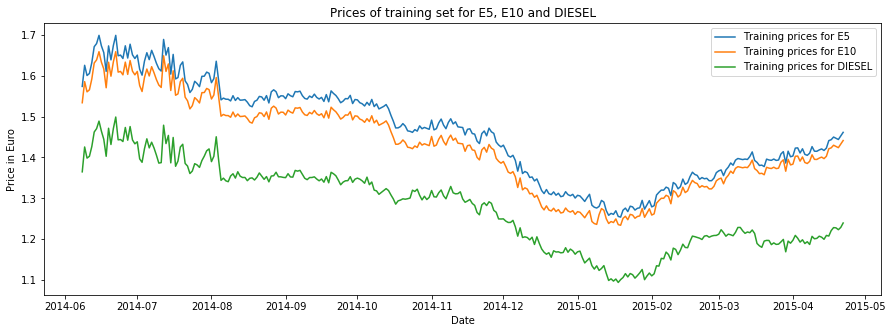

In [30]:
# Plot data
plt.figure(figsize=(15,5))
plt.plot(training_df['date'],training_df[['E5']],label = "Training prices for E5")
plt.plot(training_df['date'],training_df[['E10']],label = "Training prices for E10")
plt.plot(training_df['date'],training_df[['DIESEL']],label = "Training prices for DIESEL")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prices of training set for E5, E10 and DIESEL')
plt.legend()
plt.show()

In [31]:
#Prepare the dates we will work on, we will have a sliding window of 14 days

# get all dates of testing set
testing_dates = testing_df['date']

#get the 1st date of the testing set
first_testing_date = testing_dates.iloc[0]

#add 14 dates before the 1st date of the testing set "The 1st 14 days will be used to predict 1st value of testing et"
sliding_window_dates = testing_dates
type(sliding_window_dates)
extra_dates = []
for i in range(14):
    extra_dates.append(first_testing_date - np.timedelta64(i+1,'D'))
    
sliding_window_dates = sliding_window_dates.append(pd.Series(extra_dates))
sliding_window_dates.sort_values(inplace=True)
sliding_window_dates = sliding_window_dates.reset_index(drop=True)


In [32]:
def mean_absolute_deviation(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs(y_true - y_pred)) 

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100  

In [33]:
from sklearn.model_selection import TimeSeriesSplit
diffs = []
percentage_errors = []
prediction_df = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
mad_df_3_moving_average = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
mape_df_3_moving_average = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
tscv = TimeSeriesSplit(n_splits=sliding_window_dates.shape[0]-1,max_train_size=14)
for train, test in tscv.split(sliding_window_dates.values):
    if(train.shape[0] == 14):
        training_dates = sliding_window_dates[train]
        testing_date = sliding_window_dates[test]
        testing_date_string = pd.to_datetime(str(testing_date.dt.year.values[0])+'-'+str(testing_date.dt.month.values[0]).zfill(2)+'-'+str(testing_date.dt.day.values[0]).zfill(2))
        y_pred = average_3_stations[average_3_stations['date'].isin(training_dates)][['E5','E10','DIESEL']].mean()
        y_true = average_3_stations[average_3_stations['date'].isin(testing_date)][['E5','E10','DIESEL']]
        diff = np.abs(y_true - y_pred)
        percentage_error = (np.abs(y_true - y_pred)*100/y_true)
        prediction_df = prediction_df.append({'date' : testing_date_string, 'E5' : y_pred['E5'], 'E10' :y_pred['E10'], 'DIESEL': y_pred['DIESEL']} , ignore_index=True)
        mad_df_3_moving_average = mad_df_3_moving_average.append({'date' : testing_date_string, 'E5' : diff['E5'].values[0], 'E10' :diff['E10'].values[0], 'DIESEL': diff['DIESEL'].values[0]} , ignore_index=True)
        mape_df_3_moving_average = mape_df_3_moving_average.append({'date' : testing_date_string, 'E5' : percentage_error['E5'].values[0], 'E10' :percentage_error['E10'].values[0], 'DIESEL': percentage_error['DIESEL'].values[0]}, ignore_index=True)
        


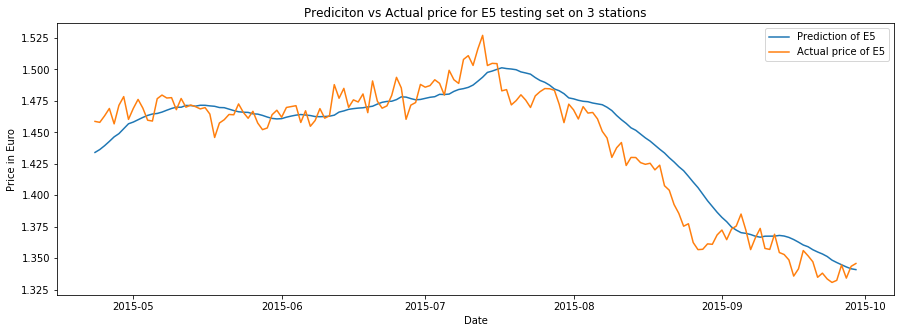

In [34]:
# Plot data of E5 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(prediction_df['date'],prediction_df[['E5']], label = "Prediction of E5")
plt.plot(testing_df['date'],testing_df[['E5']], label = "Actual price of E5")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E5 testing set on 3 stations')
plt.legend()
plt.show()

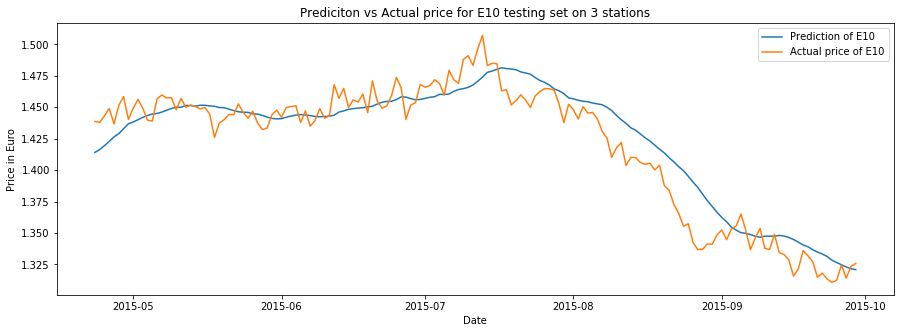

In [35]:
# Plot data of E10 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(prediction_df['date'],prediction_df[['E10']], label = "Prediction of E10")
plt.plot(testing_df['date'],testing_df[['E10']], label = "Actual price of E10")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E10 testing set on 3 stations')
plt.legend()
plt.show()

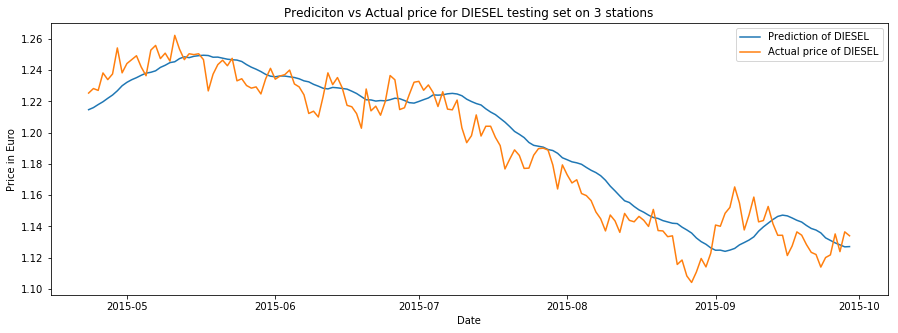

In [36]:
# Plot data of DIESEL (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(prediction_df['date'],prediction_df[['DIESEL']], label = "Prediction of DIESEL")
plt.plot(testing_df['date'],testing_df[['DIESEL']], label = "Actual price of DIESEL")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for DIESEL testing set on 3 stations')
plt.legend()
plt.show()

In [37]:
#Calculate MAD & MAPE

print("E5 MAD error using moving average: %1.4f €"  % mad_df_3_moving_average['E5'].mean())
print("E10 MAD error using moving average: %1.4f €" % mad_df_3_moving_average['E10'].mean())
print("Diesel MAD error using moving average: %1.4f €" % mad_df_3_moving_average['DIESEL'].mean())
print("\n")
print("E5 MAPE error using moving average: %3.2f %%"  % mape_df_3_moving_average['E5'].mean())
print("E10 MAPE error using moving average: %3.2f %%" % mape_df_3_moving_average['E10'].mean())
print("Diesel MAPE error using moving average: %3.2f %%" % mape_df_3_moving_average['DIESEL'].mean())


E5 MAD error using moving average: 0.0133 €
E10 MAD error using moving average: 0.0133 €
Diesel MAD error using moving average: 0.0117 €


E5 MAPE error using moving average: 0.93 %
E10 MAPE error using moving average: 0.95 %
Diesel MAPE error using moving average: 1.00 %


## 5-Working on sample data (3 stations) using fbprophet package - Step 2


In [38]:
#Import fbprophet package

from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.diagnostics import performance_metrics

ERROR:fbprophet:Importing plotly failed. Interactive plots will not work.


In [39]:
#Prepare training datasets for each gasoline type separately, and rename its columns as to Prophet format
training_e5_df = training_df.drop(['E10', 'DIESEL'], axis=1)
training_e10_df = training_df.drop(['E5', 'DIESEL'], axis=1)
training_diesel_df = training_df.drop(['E5', 'E10'], axis=1)
training_e5_df = training_e5_df.rename(columns={"date": "ds", "E5": "y"})
training_e10_df = training_e10_df.rename(columns={"date": "ds", "E10": "y"})
training_diesel_df = training_diesel_df.rename(columns={"date": "ds", "DIESEL": "y"})
training_diesel_df.describe()

,y
count,319.000000
mean,1.278172
std,0.101417
min,1.094000
25%,1.195250
50%,1.293722
75%,1.352563
max,1.499000


In [40]:
#Traing the models for each gasoline type
m_e5, m_e10, m_diesel = Prophet(), Prophet(), Prophet() 
m_e5 = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_e10 = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_diesel = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_e5 = m_e5.fit(training_e5_df)
m_e10 = m_e10.fit(training_e10_df)
m_diesel = m_diesel.fit(training_diesel_df)

In [41]:
#Prepare the future dates to predict
testing_dates = testing_df['date'].values
num_days_to_test = int((testing_dates[-1]-testing_dates[0])/ np.timedelta64(1, 'D'))+1
num_days_to_test
future_e5 = m_e5.make_future_dataframe(periods=num_days_to_test)
future_e10 = m_e10.make_future_dataframe(periods=num_days_to_test)
future_diesel = m_diesel.make_future_dataframe(periods=num_days_to_test)

In [42]:
#Predict the future

forecast_e5 = m_e5.predict(future_e5)
forecast_e10 = m_e10.predict(future_e10)
forecast_diesel = m_diesel.predict(future_diesel)
forecast_e5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_e5.shape[0]

479

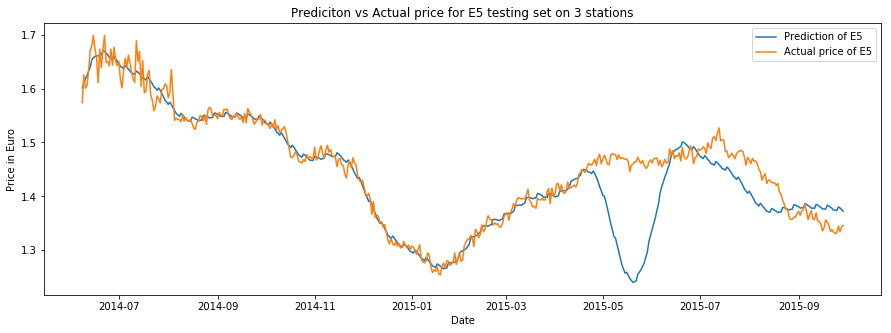

In [43]:
# Plot data of E5 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_e5['ds'],forecast_e5[['yhat']], label = "Prediction of E5")
plt.plot(average_3_stations['date'],average_3_stations[['E5']], label = "Actual price of E5")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E5 testing set on 3 stations')
plt.legend()
plt.show()

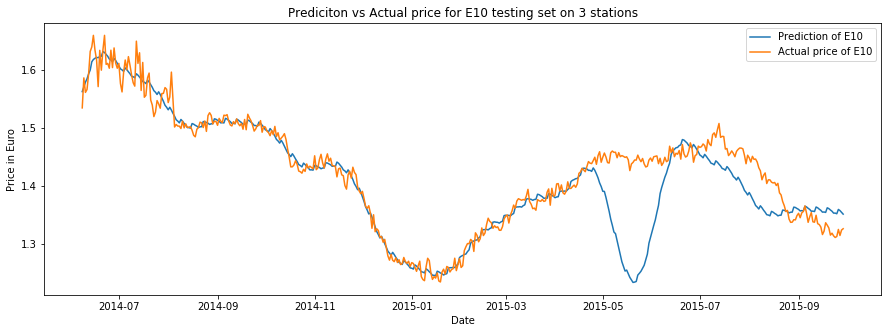

In [44]:
# Plot data of E10 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_e10['ds'],forecast_e10[['yhat']], label = "Prediction of E10")
plt.plot(average_3_stations['date'],average_3_stations[['E10']], label = "Actual price of E10")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E10 testing set on 3 stations')
plt.legend()
plt.show()

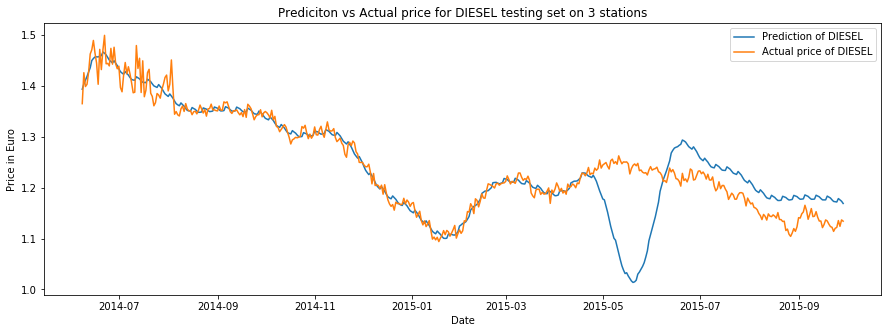

In [45]:
# Plot data of E10 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_diesel['ds'],forecast_diesel[['yhat']], label = "Prediction of DIESEL")
plt.plot(average_3_stations['date'],average_3_stations[['DIESEL']], label = "Actual price of DIESEL")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for DIESEL testing set on 3 stations')
plt.legend()
plt.show()

In [46]:
#Calculate MAD and MAPE
type(testing_df[['date','E5']])
y_true = testing_df[['date','E5','E10','DIESEL']].reset_index(drop=True)
y_hat_e5 = forecast_e5[forecast_e5['ds'].isin(y_true['date'])][['ds','yhat']].reset_index(drop=True)
y_hat_e10 = forecast_e10[forecast_e10['ds'].isin(y_true['date'])][['ds','yhat']].reset_index(drop=True)
y_hat_diesel = forecast_diesel[forecast_diesel['ds'].isin(y_true['date'])][['ds','yhat']].reset_index(drop=True)

mad_3_fb_e5, mad_3_fb_e10, mad_3_fb_diesel = np.abs(y_true['E5'] - y_hat_e5['yhat']), np.abs(y_true['E10'] - y_hat_e10['yhat']), np.abs(y_true['E5'] - y_hat_diesel['yhat'])
mape_3_fb_e5,  mape_3_fb_e10, mape_3_fb_diesel = np.abs(y_true['E5'] - y_hat_e5['yhat'])*100/y_true['E5'], np.abs(y_true['E10'] - y_hat_e10['yhat'])*100/y_true['E10'], np.abs(y_true['DIESEL'] - y_hat_diesel['yhat'])*100/y_true['DIESEL']


print("E5 MAD error using fbprophet package: %1.4f €"  % mad_3_fb_e5.mean())
print("E10 MAD error using fbprophet package: %1.4f €" % mad_3_fb_e10.mean())
print("Diesel MAD error using fbprophet package: %1.4f €" % mad_3_fb_diesel.mean())
print("\n")
print("E5 MAPE error using fbprophet package: %3.2f %%"  % mape_3_fb_e5.mean())
print("E10 MAPE error using fbprophet package: %3.2f %%" % mape_3_fb_e10.mean())
print("Diesel MAPE error using fbprophet package: %3.2f %%" % mape_3_fb_diesel.mean())

E5 MAD error using fbprophet package: 0.0612 €
E10 MAD error using fbprophet package: 0.0588 €
Diesel MAD error using fbprophet package: 0.2572 €


E5 MAPE error using fbprophet package: 4.21 %
E10 MAPE error using fbprophet package: 4.10 %
Diesel MAPE error using fbprophet package: 5.63 %


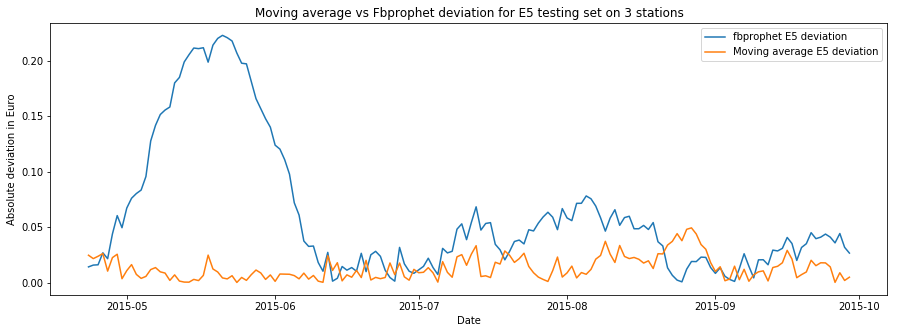

In [47]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_3_fb_e5, label = "fbprophet E5 deviation")
plt.plot(testing_df['date'],mad_df_3_moving_average['E5'], label = "Moving average E5 deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for E5 testing set on 3 stations')
plt.legend()
plt.show()

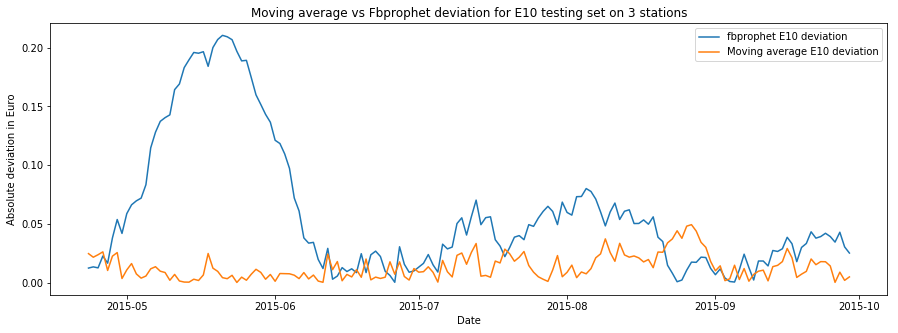

In [48]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_3_fb_e10, label = "fbprophet E10 deviation")
plt.plot(testing_df['date'],mad_df_3_moving_average['E10'], label = "Moving average E10 deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for E10 testing set on 3 stations')
plt.legend()
plt.show()

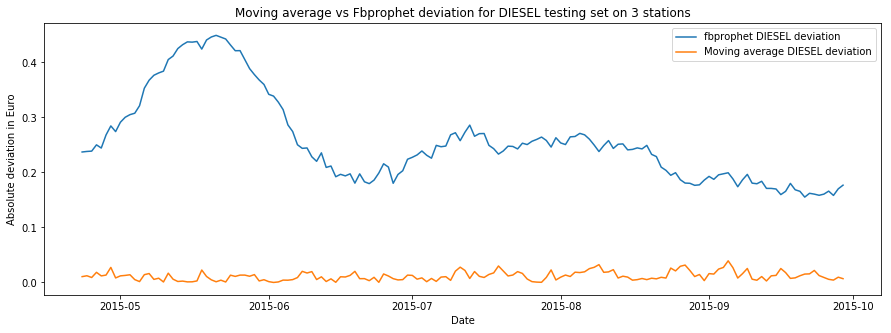

In [49]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_3_fb_diesel, label = "fbprophet DIESEL deviation")
plt.plot(testing_df['date'],mad_df_3_moving_average['DIESEL'], label = "Moving average DIESEL deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for DIESEL testing set on 3 stations')
plt.legend()
plt.show()

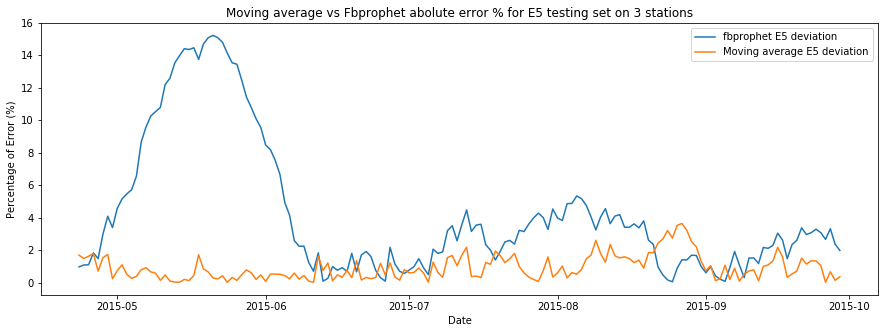

In [50]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_3_fb_e5, label = "fbprophet E5 deviation")
plt.plot(testing_df['date'],mape_df_3_moving_average['E5'], label = "Moving average E5 deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for E5 testing set on 3 stations')
plt.legend()
plt.show()

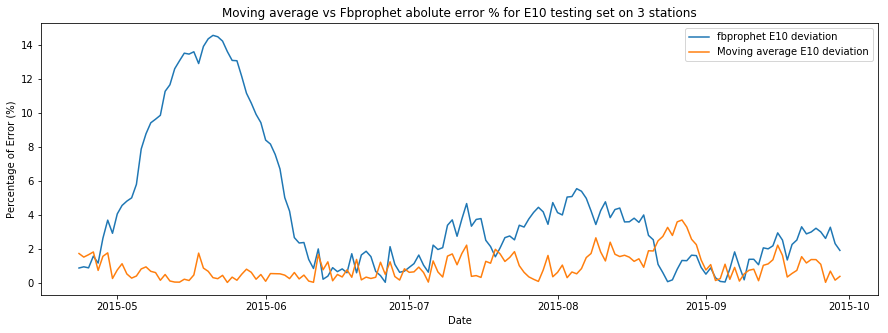

In [51]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_3_fb_e10, label = "fbprophet E10 deviation")
plt.plot(testing_df['date'],mape_df_3_moving_average['E10'], label = "Moving average E10 deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for E10 testing set on 3 stations')
plt.legend()
plt.show()

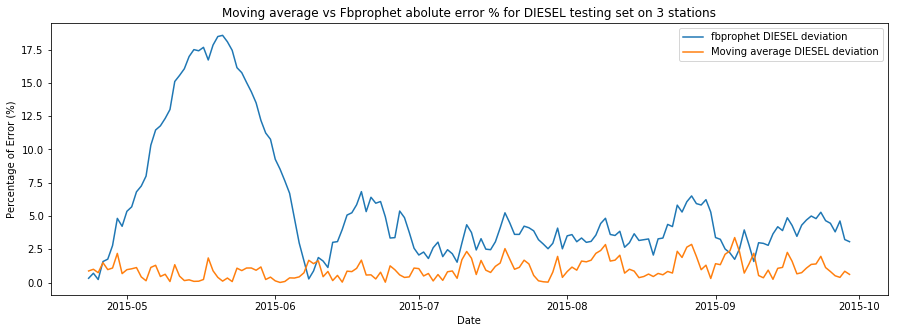

In [52]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_3_fb_diesel, label = "fbprophet DIESEL deviation")
plt.plot(testing_df['date'],mape_df_3_moving_average['DIESEL'], label = "Moving average DIESEL deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for DIESEL testing set on 3 stations')
plt.legend()
plt.show()

## 6-Working on 100 stations - Step 3


In [53]:
# Calculate using simple moving average

#Divide data to training set (2/3) and testing set (1/3)
training_df_100, testing_df_100 = np.split(average_100_stations, [int(.66666*len(average_100_stations))])

#Prepare the dates we will work on, we will have a sliding window of 14 days

# get all dates of testing set
testing_dates_100 = testing_df_100['date']
testing_dates_100.head()
#get the 1st date of the testing set
first_testing_date_100 = testing_dates_100.iloc[0]

#add 14 dates before the 1st date of the testing set "The 1st 14 days will be used to predict 1st value of testing et"
sliding_window_dates_100 = testing_dates_100
extra_dates_100 = []
for i in range(14):
    extra_dates_100.append(first_testing_date_100 - np.timedelta64(i+1,'D'))
  
sliding_window_dates_100 = sliding_window_dates_100.append(pd.Series(extra_dates_100))
sliding_window_dates_100.sort_values(inplace=True)
sliding_window_dates_100 = sliding_window_dates_100.reset_index(drop=True)
sliding_window_dates_100
diffs_100 = []
percentage_errors_100 = []
prediction_df_100 = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
mad_df_100_moving_average = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
mape_df_100_moving_average = pd.DataFrame(columns=['date', 'E5', 'E10', 'DIESEL'])
tscv_100 = TimeSeriesSplit(n_splits=sliding_window_dates_100.shape[0]-1,max_train_size=14)
for train_100, test_100 in tscv_100.split(sliding_window_dates_100.values):
    if(train_100.shape[0] == 14):
        training_dates_100 = sliding_window_dates_100[train_100]
        testing_date_100 = sliding_window_dates_100[test_100]
        testing_date_100_string = pd.to_datetime(str(testing_date_100.dt.year.values[0])+'-'+str(testing_date_100.dt.month.values[0]).zfill(2)+'-'+str(testing_date_100.dt.day.values[0]).zfill(2))
        y_pred = average_100_stations[average_100_stations['date'].isin(training_dates_100)][['E5','E10','DIESEL']].mean()
        y_true = average_100_stations[average_100_stations['date'].isin(testing_date_100)][['E5','E10','DIESEL']]
        diff = np.abs(y_true - y_pred)
        percentage_error = (np.abs(y_true - y_pred)*100/y_true)
        prediction_df_100 = prediction_df_100.append({'date' : testing_date_100_string, 'E5' : y_pred['E5'], 'E10' :y_pred['E10'], 'DIESEL': y_pred['DIESEL']} , ignore_index=True)
        mad_df_100_moving_average = mad_df_100_moving_average.append({'date' : testing_date_string, 'E5' : diff['E5'].values[0], 'E10' :diff['E10'].values[0], 'DIESEL': diff['DIESEL'].values[0]} , ignore_index=True)
        mape_df_100_moving_average = mape_df_100_moving_average.append({'date' : testing_date_string, 'E5' : percentage_error['E5'].values[0], 'E10' :percentage_error['E10'].values[0], 'DIESEL': percentage_error['DIESEL'].values[0]}, ignore_index=True)
        

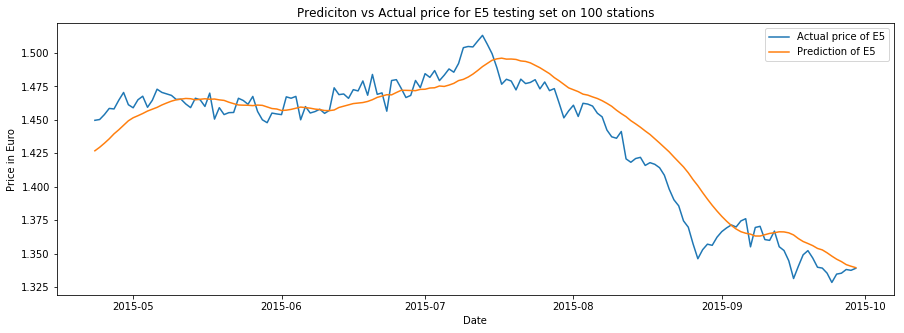

In [54]:
# Plot data of E5 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(testing_df_100['date'],testing_df_100[['E5']], label = "Actual price of E5")
plt.plot(prediction_df_100['date'].values,prediction_df_100[['E5']], label = "Prediction of E5")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E5 testing set on 100 stations')
plt.legend()
plt.show()

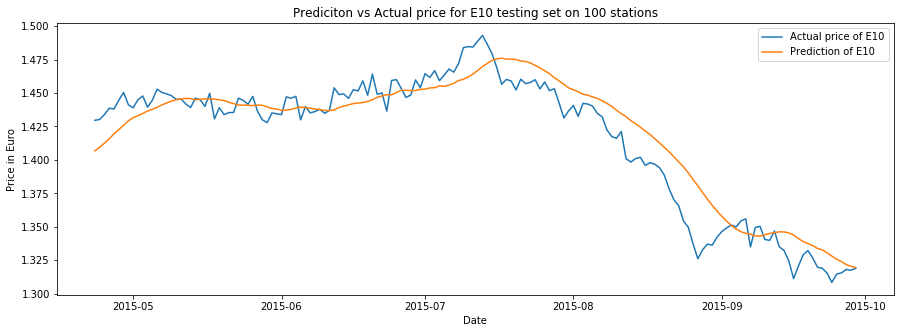

In [55]:
# Plot data of E10 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(testing_df_100['date'],testing_df_100[['E10']], label = "Actual price of E10")
plt.plot(prediction_df_100['date'].values,prediction_df_100[['E10']], label = "Prediction of E10")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E10 testing set on 100 stations')
plt.legend()
plt.show()

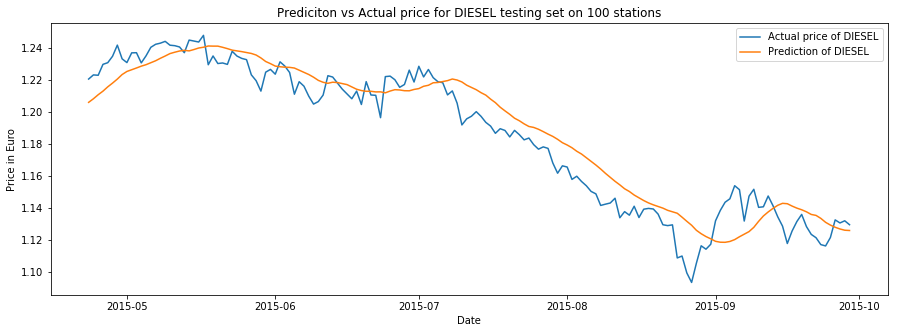

In [56]:
# Plot data of DIESEL (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(testing_df_100['date'],testing_df_100[['DIESEL']], label = "Actual price of DIESEL")
plt.plot(prediction_df_100['date'].values,prediction_df_100[['DIESEL']], label = "Prediction of DIESEL")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for DIESEL testing set on 100 stations')
plt.legend()
plt.show()

In [57]:
#Calculate MAD & MAPE

print("E5 MAD error using moving average: %1.4f €"  % mad_df_100_moving_average['E5'].mean())
print("E10 MAD error using moving average: %1.4f €" % mad_df_100_moving_average['E10'].mean())
print("Diesel MAD error using moving average: %1.4f €" % mad_df_100_moving_average['DIESEL'].mean())
print("\n")
print("E5 MAPE error using moving average: %3.2f %%"  % mape_df_100_moving_average['E5'].mean())
print("E10 MAPE error using moving average: %3.2f %%" % mape_df_100_moving_average['E10'].mean())
print("Diesel MAPE error using moving average: %3.2f %%" % mape_df_100_moving_average['DIESEL'].mean())

E5 MAD error using moving average: 0.0129 €
E10 MAD error using moving average: 0.0129 €
Diesel MAD error using moving average: 0.0112 €


E5 MAPE error using moving average: 0.91 %
E10 MAPE error using moving average: 0.92 %
Diesel MAPE error using moving average: 0.96 %


In [58]:
#The fbprophet package

#Prepare training datasets for each gasoline type separately, and rename its columns as to Prophet format
training_e5_df_100 = training_df_100.drop(['E10', 'DIESEL'], axis=1)
training_e10_df_100 = training_df_100.drop(['E5', 'DIESEL'], axis=1)
training_diesel_df_100 = training_df_100.drop(['E5', 'E10'], axis=1)
training_e5_df_100 = training_e5_df_100.rename(columns={"date": "ds", "E5": "y"})
training_e10_df_100 = training_e10_df_100.rename(columns={"date": "ds", "E10": "y"})
training_diesel_df_100 = training_diesel_df_100.rename(columns={"date": "ds", "DIESEL": "y"})
training_diesel_df.describe()


#Traing the models for each gasoline type
m_e5_100, m_e10_100, m_diesel_100 = Prophet(), Prophet(), Prophet() 
m_e5_100 = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_e10_100 = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_diesel_100 = Prophet(seasonality_prior_scale=0.1,daily_seasonality=False,
                weekly_seasonality=True,
                yearly_seasonality=True);
m_e5_100 = m_e5_100.fit(training_e5_df_100)
m_e10_100 = m_e10_100.fit(training_e10_df_100)
m_diesel_100 = m_diesel_100.fit(training_diesel_df_100)



#Prepare the future dates to predict
testing_dates_100 = testing_df_100['date'].values
num_days_to_test_100 = int((testing_dates[-1]-testing_dates[0])/ np.timedelta64(1, 'D'))+1
num_days_to_test_100
future_e5_100 = m_e5_100.make_future_dataframe(periods=num_days_to_test_100)
future_e10_100 = m_e10_100.make_future_dataframe(periods=num_days_to_test_100)
future_diesel_100 = m_diesel_100.make_future_dataframe(periods=num_days_to_test_100)


#Predict the future

forecast_e5_100 = m_e5_100.predict(future_e5_100)
forecast_e10_100 = m_e10_100.predict(future_e10_100)
forecast_diesel_100 = m_diesel_100.predict(future_diesel_100)
forecast_e5[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()
forecast_e5.shape[0]

479

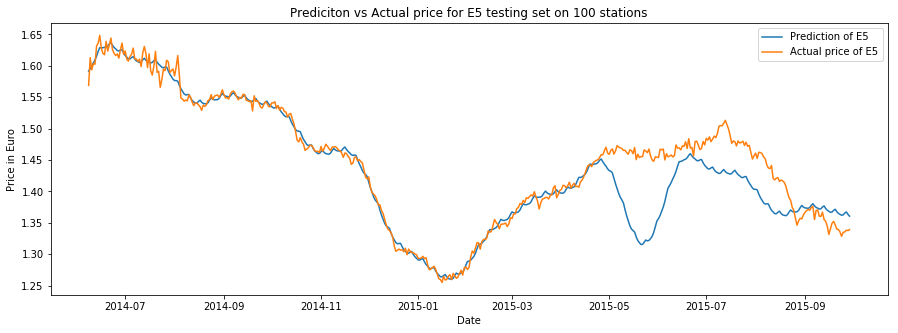

In [59]:
# Plot data of E5 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_e5_100['ds'],forecast_e5_100[['yhat']], label = "Prediction of E5")
plt.plot(average_100_stations['date'],average_100_stations[['E5']], label = "Actual price of E5")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E5 testing set on 100 stations')
plt.legend()
plt.show()

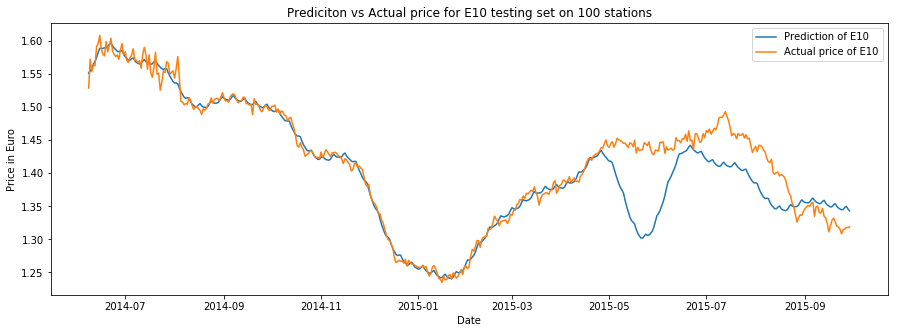

In [60]:
# Plot data of E10 (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_e10_100['ds'],forecast_e10_100[['yhat']], label = "Prediction of E10")
plt.plot(average_100_stations['date'],average_100_stations[['E10']], label = "Actual price of E10")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for E10 testing set on 100 stations')
plt.legend()
plt.show()

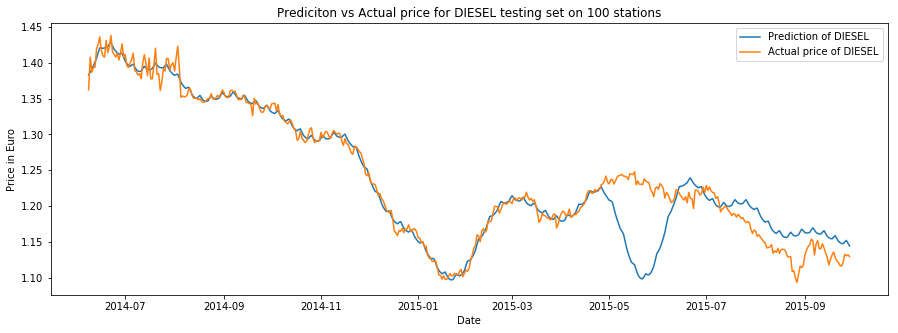

In [61]:
# Plot data of DIESEL (Prediction vs Actual value)
plt.figure(figsize=(15,5))
plt.plot(forecast_diesel_100['ds'],forecast_diesel_100[['yhat']], label = "Prediction of DIESEL")
plt.plot(average_100_stations['date'],average_100_stations[['DIESEL']], label = "Actual price of DIESEL")
plt.xlabel('Date')
plt.ylabel('Price in Euro');
plt.title('Prediciton vs Actual price for DIESEL testing set on 100 stations')
plt.legend()
plt.show()

In [62]:
#Calculate MAD and MAPE

y_true_100 = testing_df_100[['date','E5','E10','DIESEL']].reset_index(drop=True)
y_hat_e5_100 = forecast_e5_100[forecast_e5_100['ds'].isin(y_true_100['date'])][['ds','yhat']].reset_index(drop=True)
y_hat_e10_100 = forecast_e10_100[forecast_e10_100['ds'].isin(y_true_100['date'])][['ds','yhat']].reset_index(drop=True)
y_hat_diesel_100 = forecast_diesel_100[forecast_diesel_100['ds'].isin(y_true_100['date'])][['ds','yhat']].reset_index(drop=True)
mad_100_fb_e5, mad_100_fb_e10, mad_100_fb_diesel = np.abs(y_true_100['E5'] - y_hat_e5_100['yhat']), np.abs(y_true_100['E10'] - y_hat_e10_100['yhat']), np.abs(y_true_100['E5'] - y_hat_diesel_100['yhat'])
mape_100_fb_e5,  mape_100_fb_e10, mape_100_fb_diesel = np.abs(y_true_100['E5'] - y_hat_e5_100['yhat'])*100/y_true_100['E5'], np.abs(y_true_100['E10'] - y_hat_e10_100['yhat'])*100/y_true_100['E10'], np.abs(y_true_100['DIESEL'] - y_hat_diesel_100['yhat'])*100/y_true_100['DIESEL']


print("E5 MAD error using fbprophet package: %1.4f €"  % mad_3_fb_e5.mean())
print("E10 MAD error using fbprophet package: %1.4f €" % mad_3_fb_e10.mean())
print("Diesel MAD error using fbprophet package: %1.4f €" % mad_3_fb_diesel.mean())
print("\n")
print("E5 MAPE error using fbprophet package: %3.2f %%"  % mape_3_fb_e5.mean())
print("E10 MAPE error using fbprophet package: %3.2f %%" % mape_3_fb_e10.mean())
print("Diesel MAPE error using fbprophet package: %3.2f %%" % mape_3_fb_diesel.mean())

E5 MAD error using fbprophet package: 0.0612 €
E10 MAD error using fbprophet package: 0.0588 €
Diesel MAD error using fbprophet package: 0.2572 €


E5 MAPE error using fbprophet package: 4.21 %
E10 MAPE error using fbprophet package: 4.10 %
Diesel MAPE error using fbprophet package: 5.63 %


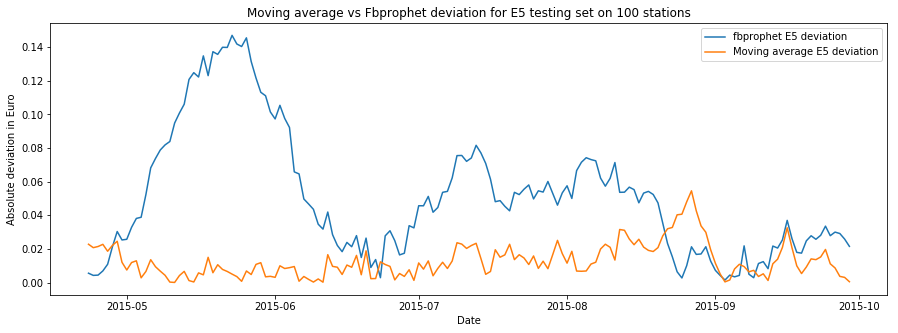

In [63]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_100_fb_e5, label = "fbprophet E5 deviation")
plt.plot(testing_df['date'],mad_df_100_moving_average['E5'], label = "Moving average E5 deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for E5 testing set on 100 stations')
plt.legend()
plt.show()

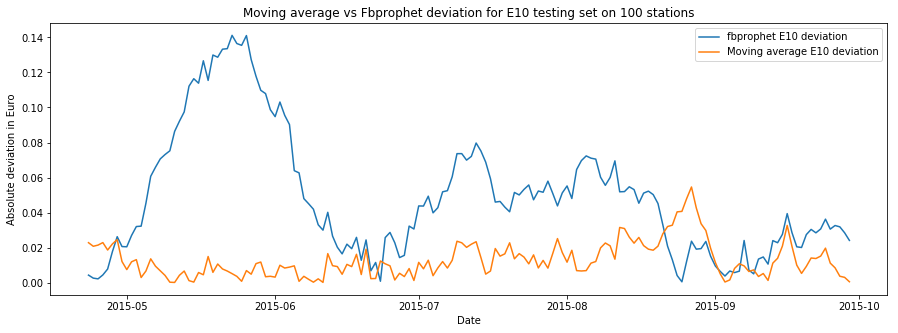

In [64]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_100_fb_e10, label = "fbprophet E10 deviation")
plt.plot(testing_df['date'],mad_df_100_moving_average['E10'], label = "Moving average E10 deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for E10 testing set on 100 stations')
plt.legend()
plt.show()

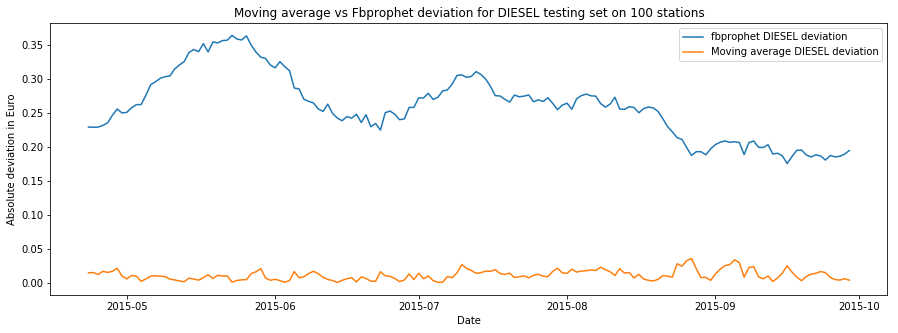

In [65]:
#Absolute deviation (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mad_100_fb_diesel, label = "fbprophet DIESEL deviation")
plt.plot(testing_df['date'],mad_df_100_moving_average['DIESEL'], label = "Moving average DIESEL deviation")
plt.xlabel('Date')
plt.ylabel('Absolute deviation in Euro');
plt.title('Moving average vs Fbprophet deviation for DIESEL testing set on 100 stations')
plt.legend()
plt.show()

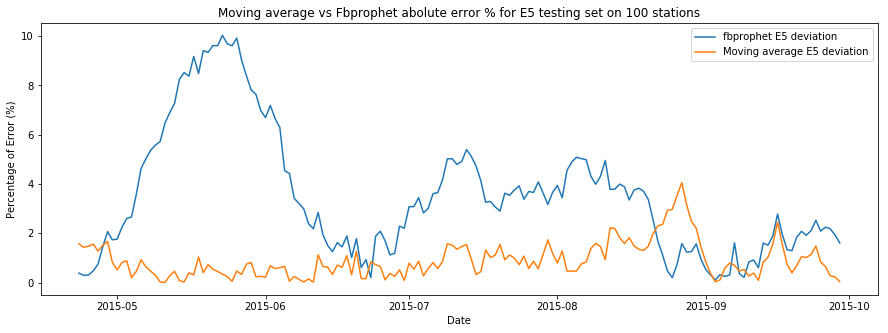

In [66]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_100_fb_e5, label = "fbprophet E5 deviation")
plt.plot(testing_df['date'],mape_df_100_moving_average['E5'], label = "Moving average E5 deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for E5 testing set on 100 stations')
plt.legend()
plt.show()

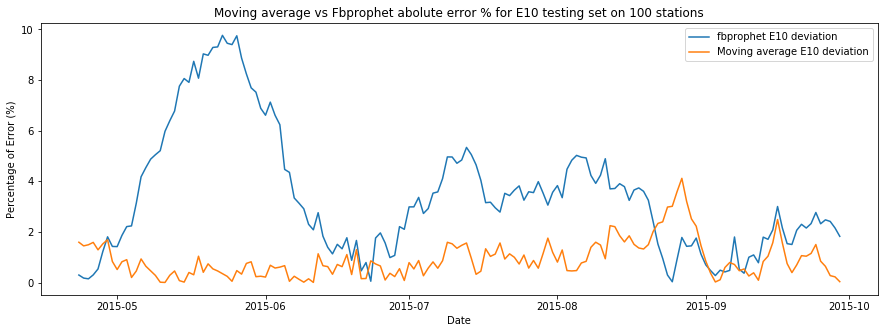

In [67]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_100_fb_e10, label = "fbprophet E10 deviation")
plt.plot(testing_df['date'],mape_df_100_moving_average['E10'], label = "Moving average E10 deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for E10 testing set on 100 stations')
plt.legend()
plt.show()

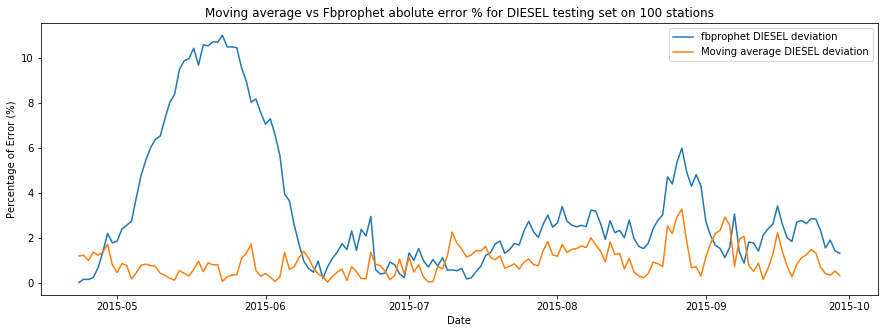

In [68]:
#Absolute Percentage Error (Sliding window vs Fbprophet)

plt.figure(figsize=(15,5))
plt.plot(testing_df['date'],mape_100_fb_diesel, label = "fbprophet DIESEL deviation")
plt.plot(testing_df['date'],mape_df_100_moving_average['DIESEL'], label = "Moving average DIESEL deviation")
plt.xlabel('Date')
plt.ylabel('Percentage of Error (%)');
plt.title('Moving average vs Fbprophet abolute error % for DIESEL testing set on 100 stations')
plt.legend()
plt.show()

### The Moving average results are relatively better than the fbprophet package, specially due to the bad prediction of the fbprophet page during the month of 2015-05 (The start of the testing set)